In [1]:
!pip install torch transformers evaluate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install fsspec==2023.9.2 # Provee una interfaz unificada para interactuar con diversos tipos de archivos de sistema

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.9.2 which is incompatible.


In [3]:
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py


TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [4]:
# the model name
## 16: patch size
## 224: input image size
model_name = "google/vit-base-patch16-224"
# load the image processor
## ViTImageProcessor: Normalize the image (resize to 224x224,
## normalize the values by the mean and standard deviation, and convert to tensor)
image_processor = ViTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
## ViTForImageClassification: Load the pre-trained model for image classification
model = ViTForImageClassification.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



config.json: 0.00B [00:00, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/config.json
Model config ViTConfig {
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/model.safetensors


### Auxiliar functions to load an image from an URL

In [5]:
import urllib.parse as parse
import os

# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# a function to load an image
def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

In [6]:
def get_prediction(model, url_or_path):
  # load the image
  img = load_image(url_or_path)
  # preprocessing the image
  pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
  #print(pixel_values)
  # perform inference
  output = model(pixel_values)
  # get the label id and return the class name
  return model.config.id2label[int(output.logits.softmax(dim=1).argmax())]

In [7]:
model = model.to(device)
get_prediction(model, "http://images.cocodataset.org/test-stuff2017/000000000128.jpg")

'Indian elephant, Elephas maximus'

In [8]:
from datasets import load_dataset

# download & load the dataset
## It contains images of food, organized by type of food.
ds = load_dataset("food101")
ds

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [9]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'mac

In [10]:
import random
import matplotlib.pyplot as plt

def show_image_grid(dataset, split, grid_size=(4,4)):
    # Select random images from the given split
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]

    # Display the images in a grid
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(ds["train"].features["label"].int2str(labels[i]))

    plt.show()

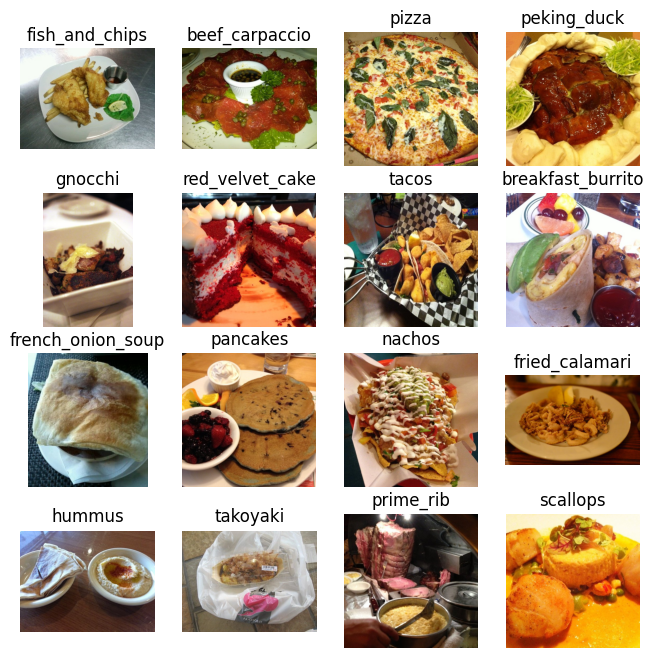

In [11]:
show_image_grid(ds, "train")

In [12]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it
  # using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]
  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [13]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
6


In [14]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

The **collate_fn** function, joints multiple individual objects from the dataset in one batch.

In [15]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [16]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [17]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True, # replace the classification layer
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/config.json
Model config ViTConfig {
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "10": "bruschetta",
    "100": "waffles",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "2": "baklava",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",
    "25": "club_sandwich",
    "26": "crab_cakes",
    "27": "creme_brulee",
    "28": "croque_madame",


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-food", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=4, # batch size per device during training
  eval_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)

PyTorch: setting up devices


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

/tmp/ipython-input-2589878313.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# start training
trainer.train()

***** Running training *****
  Num examples = 75,750
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 56,814
  Number of trainable parameters = 85,876,325


Step,Training Loss,Validation Loss,Accuracy,F1
1000,2.706300,1.341286,0.706059,0.691488
2000,1.251900,0.882004,0.776515,0.775501
3000,1.022300,0.784097,0.790099,0.787963
4000,0.974800,0.733488,0.802851,0.802233
5000,0.972800,0.706199,0.809782,0.811683
6000,0.917900,0.653587,0.822851,0.820631
7000,0.893400,0.668577,0.819208,0.820814
8000,0.854800,0.680887,0.816475,0.816484
9000,0.874700,0.683180,0.816198,0.815293
10000,0.838400,0.610282,0.837307,0.836272



***** Running Evaluation *****
  Num examples = 25250
  Batch size = 8
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Saving model checkpoint to ./vit-base-food/checkpoint-1000
Configuration saved in ./vit-base-food/checkpoint-1000/config.json
Model weights saved in ./vit-base-food/checkpoint-1000/model.safetensors
Image processor saved in ./vit-base-food/checkpoint-1000/preprocessor_config.json

***** Running Evaluation *****
  Num examples = 25250
  Batch size = 8
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Saving model checkpoint to ./vit-base-food/checkpoint-2000
Configuration saved in ./vit-base-food/checkpoint-2000/config.json
Model weights saved in ./vit-base-food/checkpoint-2000/model.safetensors
Image processor saved in ./vit-base-food/checkpoint-2000/preprocessor_config.json
/usr/local/lib/python3.12/dist-packages/

In [ ]:
trainer.evaluate(dataset["validation"])

In [ ]:
print("Número de labels:", model.config.num_labels)
print("id2label:", model.config.id2label)

In [ ]:
model.config.id2label = {int(k): v for k, v in model.config.id2label.items()}
get_prediction(model, "https://images.pexels.com/photos/858496/pexels-photo-858496.jpeg?auto=compress&cs=tinysrgb&w=600&lazy=load")

In [ ]:
def get_prediction_probs(model, url_or_path, num_classes=3):
    # load the image
    img = load_image(url_or_path)
    # preprocessing the image
    pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
    # perform inference
    output = model(pixel_values)
    # get the top k classes and probabilities
    probs, indices = torch.topk(output.logits.softmax(dim=1), k=num_classes)
    # get the class labels
    id2label = model.config.id2label
    classes = [id2label[idx.item()] for idx in indices[0]]
    # convert the probabilities to a list
    probs = probs.squeeze().tolist()
    # create a dictionary with the class names and probabilities
    results = dict(zip(classes, probs))
    return results

In [ ]:
# example 1
get_prediction_probs(model, "https://images.pexels.com/photos/406152/pexels-photo-406152.jpeg?auto=compress&cs=tinysrgb&w=600")

In [ ]:
# example 2
get_prediction_probs(model, "https://images.pexels.com/photos/920220/pexels-photo-920220.jpeg?auto=compress&cs=tinysrgb&w=600")

In [ ]:
# example 3
get_prediction_probs(model, "https://images.pexels.com/photos/3338681/pexels-photo-3338681.jpeg?auto=compress&cs=tinysrgb&w=600")

In [ ]:
# example 4
get_prediction_probs(model, "https://images.pexels.com/photos/806457/pexels-photo-806457.jpeg?auto=compress&cs=tinysrgb&w=600", num_classes=10)